<a href="https://colab.research.google.com/github/goodwiins/CSCI358_LM/blob/main/SVM_2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

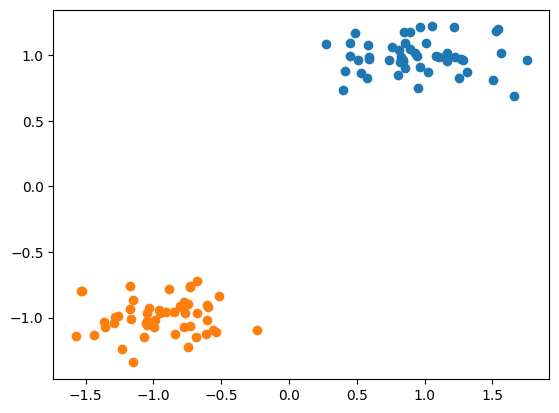

In [7]:
### The setting..

### This code sets up some artificial data to work with throughout the worksheet.

from sklearn.datasets import make_blobs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

X,y = make_blobs(centers=2,random_state=11)
ss = StandardScaler()
X = ss.fit_transform(X)
y = 2*y-1
Xr = X[y==1]
Xb = X[y==-1]
plt.scatter(Xr[:,0],Xr[:,1])
plt.scatter(Xb[:,0],Xb[:,1])
plt.show()


In [8]:
X = np.c_[np.ones(X.shape[0]),X]

## Support Vector Machines


The basic idea of the SVM is to find a **maximum margin** separator.

![img](margin.png)


As with the linear model, the SVM is based on the hyperplane

$$\bar{w}^T\bar{x}$$

Because scaling affects the width of the margin, SVM methods are sensitive to data scaling.

---


In classification the hypothesis class is the same as linear classification:

$$\mathcal{H} = \{sign(\bar{w}^T\bar{x}) : \bar{w} \in \mathbb{R}^{d+1}\}$$

The difference is just the algorithm for finding the best $\bar{w}$.

---

The above notation employs our usual convention that $\bar{w} = [w_0,w_1,\ldots,w_d]^T$ and $\bar{x} = [x_0,x_1,\ldots,x_d]^T$ where $x_0 = 1$ is the bias coordinate.

But because of the way SVMs work it is more convenient to use the notation $b = w_0$, $\bar{w} = [w_1,\ldots,w_d]^T$ and $\bar{x} = [x_1,\ldots,x_d]^T$.

Then we express the hyperplane like this:

$$\bar{w}^T\bar{x} + b$$

It says the same thing, just in different notation.

To avoid confusion I will express this as

$$\bar{w}^T_{[1:]}\bar{x}_{[1:]} + b$$

with the understanding that $b=w_0$.

Then we can keep our familiar notation and

$$\bar{w}^T\bar{x} = \bar{w}^T_{[1:]}\bar{x}_{[1:]} + b$$



#### Decision boundary

As usual, the decision boundary is given by the equation

$$\bar{w}^T\bar{x} = 0.$$

The margin lines are (by definition) given by the equations

$$\bar{w}^T\bar{x} = 1$$

and

$$\bar{w}^T\bar{x} = -1.$$

To fully understand this, remember that the decision boundary is really the intersection of the **plane** $z = \bar{w}^T\bar{x}$ and the $xy$ plane.

![img](2d.png)

![img](3d2.png)

In the above plot, the decision boundary is where the mesh plane intersects the $xy$ or $z=0$ plane.  

The upper margin is where the mesh plane intersects the $z=1$ plane (projected down to $xy$).

The lower margin is where the mesh plane intersects the $z=-1$ plane (projected down to $xy$).

---

#### Slope and margin width

Notice that the locations of the margin depend on the slope of the mesh plane.

The plane *must* go through the decision boundary, but it could do so with varying degrees of steepness.

The steeper the angle, the narrower the margin will be.

Observe that $\nabla_{\bar{x}_{[1:]}} \bar{w}^T\bar{x} = \bar{w}_{[1:]}$.

Therefore the direction of increase for the mesh plane is $\bar{w}_{[1:]}$.

And the steepness is controlled by $|\!|\bar{w}_{[1:]}|\!|$.

The smaller $|\!|\bar{w}_{[1:]}|\!|$ is, more gradual the slope, the wider the margin.

When $|\!|\bar{w}_{[1:]}|\!|$ is large, the opposite is true -- the margins are narrow and the slope is steep.

---


### Hard margin classification


In hard margin classification we assume that the data is linearly separable.

Then we try to find the boundary that admits the widest margin.

We can phrase everything as an optimization problem.

The goal is to maximize the margin width, while ensuring that the data is correctly classified by the "thick" decision boundary.

---

### The optimization problem

Recall that maximizing margin width means minimizing $|\!|\bar{w}_{[1:]}|\!|$.

Equivalently we can minimize that more convenient expression $\frac{1}{2}|\!|\bar{w}_{[1:]}|\!|^2$.

And we want to do this subject to these constraints:

$\bar{w}^T\bar{x}^{(n)} \geq 1$ whenever $y^{(n)} = 1$

and

$\bar{w}^T\bar{x}^{(n)} \leq -1$ whenever $y^{(n)} = -1$

More succinctly, we want to

**minimize**  $\frac{1}{2}|\!|\bar{w}_{[1:]}|\!|^2$

**subject to** $y^{(n)}(\bar{w}^T\bar{x}^{(n)}) \geq 1$ for all $n=1,2,\ldots,N$.

There is one constraint for each training data point.




### Solving the  optimization problem

Before when we wanted to do optimization we used gradient descent or the normal equations (for linear regression).

But here we will do something different.

The optimization problem defined by an SVM is an example of a **quadratic programming** (QP) problem.

Quadratic programming problems are very well understood and there are a number of QP solving libraries that can be used to train a SVM.

---

A discussion of QP is beyond the scope of our class.

But the basic idea is to find the optimum of a linearly constrained set subject to a quadratic function.

![img](quadratic-programming.jpg)

---

There are a number of QP solvers available in python:  CVXOPT, CVXPY, Gurobi, MOSEK, qpOASES and quadprog.

We will use quadprog.

---

### Defining the QP problem

The following formally defines a QP problem.

**Minimize**     $\frac{1}{2} \bar{w}^T G \bar{w} - \bar{a}^T \bar{w}$

**Subject to**   $A\bar{w} \geq \bar{v}$

The first line gives a general quadratic function of $\bar{w}$.

The second line gives a **system** of inequalities (one for each dimension of $\bar{v}$).

Here:

1. $G$ is a $d\times d$ matrix.
2. $\bar{a}$ is a $d$ dimensional vector.
3. $A$ is a $k \times d$ matrix.
4. $\bar{v}$ is a $k$ dimensional vector.

I have expressed the variables to optimize as $\bar{w}$ to give a big hint as to how this will work for hard margin classification.

But be mindful that the variables could have other meanings (as they will in soft-margin classification).

The QP problem and QP solvers do not care about any particular meaning of the elements as it relates to the SVM problem.

---

### Connecting QP and SVM

Notice that the thing we want to minimize in the SVM problem is

$\frac{1}{2}|\!|\bar{w}_{[1:]}|\!|^2 = \frac{1}{2}\bar{w}_{[1:]}^T\bar{w}_{[1:]}$

We can realize this as $\frac{1}{2} \bar{w}^T G \bar{w} - \bar{a}^T \bar{w}$ by

1. making $G = I$, except $G_{0,0}$, which will be 0,
2. and by making $\bar{a} = \bar{0}$.

The constraints in the SVM problem are $y^{(n)}(\bar{w}^T\bar{x}^{(n)}) \geq 1$ for all $n=1,2,\ldots,N$.

We can realize this as $A\bar{w} \geq \bar{v}$ in the following way.

First, $A$ will have $k=N$ rows.

The $i$ th row of $A$ will be $y^{(i)}\bar{x}^{(i)}$.

The vector $\bar{v}$ can simply be a vector of $N$ ones.



---


To simplify the transition from the equations to the code, we will formally define the QP problem using the notation used in the quadprog documentation.

You can see the docs by loading

```
import quadprog as qp
qp.solve_qp?
```

Which produces

```
Docstring:
Solve a strictly convex quadratic program

Minimize     1/2 x^T G x - a^T x
Subject to   C.T x >= b

This routine uses the the Goldfarb/Idnani dual algorithm [1].

References
---------
... [1] D. Goldfarb and A. Idnani (1983). A numerically stable dual
    method for solving strictly convex quadratic programs.
    Mathematical Programming, 27, 1-33.

Parameters
----------
G : array, shape=(n, n)
    matrix appearing in the quadratic function to be minimized
a : array, shape=(n,)
    vector appearing in the quadratic function to be minimized
C : array, shape=(n, m)
    matrix defining the constraints under which we want to minimize the
    quadratic function
b : array, shape=(m), default=None
    vector defining the constraints
meq : int, default=0
    the first meq constraints are treated as equality constraints,
    all further as inequality constraints (defaults to 0).
factorized : bool, default=False
    If True, then we are passing :math:`R^{−1}` (where :math:`G = R^T R`)
    instead of the matrix G in the argument G.

Returns
-------
x : array, shape=(n,)
    vector containing the solution of the quadratic programming problem.
f : float
    the value of the quadratic function at the solution.
xu : array, shape=(n,)
    vector containing the unconstrained minimizer of the quadratic function
iterations : tuple
    2-tuple. the first component contains the number of iterations the
    algorithm needed, the second indicates how often constraints became
    inactive after becoming active first.
lagrangian : array, shape=(m,)
    vector with the Lagragian at the solution.
iact : array
    vector with the indices of the active constraints at the solution.
Type:      builtin_function_or_method
```

Notice that `quadprog` uses `x` for our $\bar{w}$ and `b` for our $\bar{v}$.

We will not use the optional parameters `meq` or `factorized`.

For reasons that are unclear `quadprog` prefers to think of our $A$ as being the transpose of another matrix called $C$.  

We generally only care about the 0th entry of the vector returned by `quadprog`, which is our $\bar{w}$.

---

### Exercise

Below, use quadprog to find the maximum margin $\bar{w}$ for the blob data loaded above.

The solver will not like it if a row or column of $G$ is all zeros.

After you set up $G$ add a "sprinkling" of small constants on the diagonal:

```
G = G + np.eye(X.shape[1])*10**(-9)
```

This ensures that $G$ is *positive-definite*, meaning $\bar{w}^TG\bar{w} > 0$.
.

In [11]:
!pip install quadprog
import quadprog as qp

dim = X.shape[1]
G = np.eye(dim)
G[0,0] = 10**(-9)
a = np.zeros(dim)
A=y.reshape(X.shape[0],-1)*X
C=A.T
v = np.ones(X.shape[0])
w = qp.solve_qp(G,a,C,v)[0]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 534.6/534.6 kB 7.0 MB/s eta 0:00:00


In [12]:
w = np.random.randn(3)


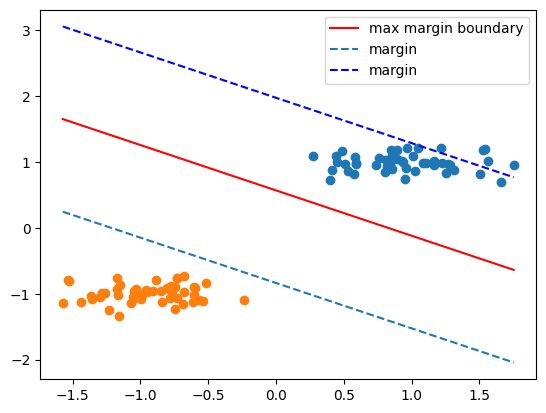

In [13]:
left = np.min(X[:,1])
right = np.max(X[:,1])
xx = np.linspace(left,right)
yy = -(w[0]+w[1]*xx)/w[2]
plt.plot(xx,yy,c='r',label="max margin boundary")
yy_um = -(w[0]+w[1]*xx-1)/w[2]
plt.plot(xx,yy_um,'--',label="margin")
yy_um = -(w[0]+w[1]*xx+1)/w[2]
plt.plot(xx,yy_um,'--',c='b',label="margin")

plt.scatter(Xr[:,0],Xr[:,1])
plt.scatter(Xb[:,0],Xb[:,1])
plt.legend()
plt.show()


### Support vectors

Given that this learning algorithm is called a Support Vector Machine, we should mention support vectors.

These are just the training points that are exactly on the margins.

In other words they are the training points $(\bar{x}^{(n)},y^{(n)})$ such that

$$y^{(n)}\bar{w}^T\bar{x}^{(n)} = \pm 1$$

Below we find the support vectors for the above problem.

Given their coordinates, you can find them in the plot above.


In [14]:
## The support vectors...

[(w.dot(x),(x[1],x[2])) for x in X if np.isclose(w.dot(x),1) or np.isclose(w.dot(x),(-1))  ]

[]

### A 3D view

Here is a 3-dimensional view of the same decision boundary.

Try to use it to understand why $\bar{w}^T\bar{x} = \pm 1$ gives different margins depending on $\bar{w}$.


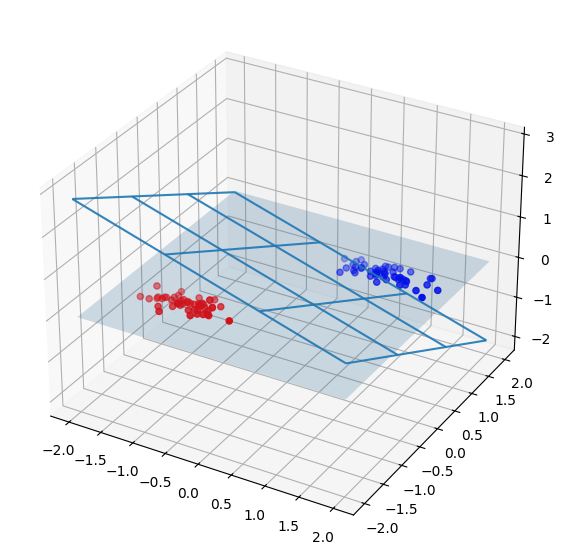

In [15]:

from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt

x = np.linspace(-2, 2, 30)
y = np.linspace(-2, 2, 30)

XX, YY = np.meshgrid(x, y)
ZZ = w[0]+w[1]*XX+w[2]*YY


fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')
#ax2 = fig.add_subplot(212, projection='3d')
# Grab some test data.
#X, Y, Z = axes3d.get_test_data(0.05)

# Plot a basic wireframe.
ax.plot_wireframe(XX, YY, ZZ, rstride=10, cstride=10,alpha=0.9)

ax.plot_surface(XX, YY, 0*XX, rstride=10, cstride=10,alpha=0.2)


ax.scatter(Xr[:,0], Xr[:,1], np.zeros(Xr.shape[0]),c='b')
ax.scatter(Xb[:,0], Xb[:,1], np.zeros(Xr.shape[0]),c='r')

"""
ax2.plot_wireframe(XX, YY, 3*ZZ, rstride=10, cstride=10,alpha=0.9)

ax2.plot_surface(XX, YY, 0*XX, rstride=10, cstride=10,alpha=0.2)


ax2.scatter(Xr[:,0], Xr[:,1], np.zeros(Xr.shape[0]),c='r')
ax2.scatter(Xb[:,0], Xb[:,1], np.zeros(Xr.shape[0]),c='b')
"""

plt.show()

### Soft margin

You can use the hard margin method for linearly separable data, but most real data is not perfectly linearly separable.

Additionally the hard margin approach is sensitive to outliers.  

An outlying data point can significantly change the best margin boundary.

---

To relax the hard margin assumption of linear separability, we have to allow **margin violations**.

This means we have to allow points inside the margin, and even allow points on the wrong side of the decision boundary.  

While doing this, we still want to stay true to the "wide margin" principle.  

The key idea that makes this possible is a **slack variable**.

We usually denote slack variables as $\zeta$, the Greek letter zeta.

---

### Slack variables

For every training point $(\bar{x}^{(n)}, y^{(n)})$ we will associate a slack variable $\zeta^{(n)}$.  

The slack variable measures how far $\bar{x}^{(n)}$ is from being on the right side of the margin.

If $\bar{x}^{(n)}$ is actually on the correct side of the margin then $\zeta^{(n)} = 0$.

In hard margin we require $y^{(n)}\bar{w}^T\bar{x}^{(n)} \geq 1$.

With slack variables we only require $y^{(n)}\bar{w}^T\bar{x}^{(n)} \geq 1-\zeta^{(n)}$,

where $\zeta^{(n)} \geq 0$.

![img](slack.jpeg)

Notice that slack variables are always nonnegative.

---

### The soft margin optimization problem

In soft margin classification, we want to maximize the width of the margin, but we also want to minimize the amount of slack we need.  

Mathematically we want to

**minimize** $$\frac{1}{2}\bar{w}^T_{[1:]}\bar{w}_{[1:]} + C\sum_{i=1}^N \zeta^{(i)}$$

**subject to**

$y^{(n)}\bar{w}^T\bar{x}^{(n)} \geq 1-\zeta^{(n)}$ and $\zeta^{(n)} \geq 0$ for $n=1,2\ldots,N$.


The minimization is with respect to the variables $\bar{w},\zeta^{(1)},\zeta^{(2)},\ldots,\zeta^{(N)}$.

To be clear:  **we now want to minimize an expression that involves $d+1+N$ variables**.

---

The constant $C$ is a nonzero hyperparameter that lets us balance two competing wants:

1. the widest possible margins
2. the most benign possible margin violations

If $C$ is large then margin violations will be heavily penalized, causing the margin to be smaller.

If $C$ is small then margin violations are only lightly penalized, and the margin is allowed to be wider.

We give some plots below showing the effect of shrinking $C$.

![img](sm1.png)

![img](sm2.png)


### The soft margin QP problem

The soft margin constraint is still a quadratic programming problem.

**Minimize**     $\frac{1}{2} \bar{z}^T G \bar{z} - \bar{a}^T \bar{z}$

**Subject to**   $A\bar{z} \geq \bar{v}$


Here I have made the variables $\bar{z}$ minimized by the QP solver into the deliberately abstract $\bar{z}$.

Now we will use $\bar{z} = [w_0,w_1,w_2,\ldots,w_d,\zeta^{(1)},\zeta^{(2)},\ldots,\zeta^{(N)}]$.

We need to choose $G$ so that $\bar{z}^T G \bar{z} = \frac{1}{2}\bar{w}^T_{[1:]}\bar{w}_{[1:]}$.

We need to chose $\bar{a}$ so that $\bar{a}^T\bar{z} = -C\sum_{i=1}^N\zeta^{(i)}$.

Finally we need to choose $A$ and $\bar{v}$ so that $A\bar{z} \geq \bar{v}$ expresses both $$y^{(n)}\bar{w}^T\bar{x}^{(n)} \geq 1-\zeta^{(n)}$$ as well as $\zeta^{(n)} \geq 0$ for all $i=1,2,\ldots,N$.

### Exercise:

Implement a soft margin SVM in the function `svm-fit` below.  

Hint:  Try to write $G$, $A$, and $\bar{v}$ out in "block matrix" form to see what to do.


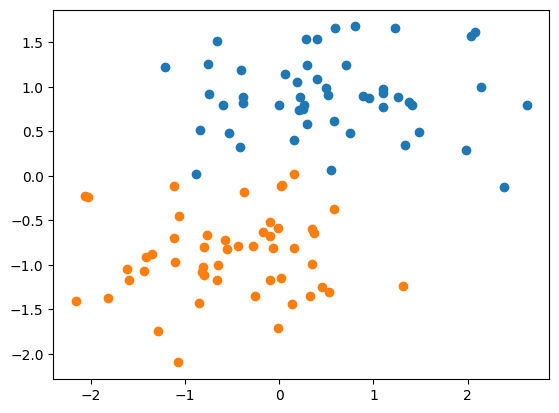

In [29]:

X,y = make_blobs(centers=2,cluster_std = 4,random_state=11)
ss = StandardScaler()
X = ss.fit_transform(X)
y = 2*y-1
Xr = X[y==1]
Xb = X[y==-1]
plt.scatter(Xr[:,0],Xr[:,1])
plt.scatter(Xb[:,0],Xb[:,1])
plt.show()

In [30]:
X = np.c_[np.ones(X.shape[0]),X]

In [35]:
import numpy as np
import quadprog as qp

def svm_fit(X, y, C_svm=1.0):
    """
    Fits a soft-margin SVM classifier using the primal quadratic program.
    """
    n_samples, n_features = X.shape
    n_vars = n_features + n_samples

    # --- 1. Construct G (FIX for Positive Definite) ---
    # Start with jitter (1e-9) on the *entire* diagonal
    G = np.eye(n_vars) * 1e-9
    # Add regularization '1' for non-bias weights (w_1, w_2, ...)
    G[1:n_features, 1:n_features] = 1.0

    # --- 2. Construct a (FIX for C_svm) ---
    # Apply -C_svm penalty to *all* xi variables
    a = np.zeros(n_vars)
    a[n_features:] = -C_svm  # <-- FIX 2

    # --- 3. Construct C (Your C was correct) ---
    # Part 1: y_i * (w.T * x_i) + xi_i >= 1
    A = y.reshape(n_samples, -1) * X
    I_n = np.eye(n_samples)
    C_T_1 = np.hstack([A, I_n])

    # Part 2: xi_i >= 0
    Zero_block = np.zeros((n_samples, n_features))
    C_T_2 = np.hstack([Zero_block, I_n])

    # Stack constraints
    C_T = np.vstack([C_T_1, C_T_2])
    C = C_T.T  # Final C matrix (n_vars, 2*n_samples)

    # --- 4. Construct v (Your v was correct) ---
    v_1 = np.ones(n_samples)
    v_2 = np.zeros(n_samples)
    v = np.hstack([v_1, v_2]) # Final v vector (2*n_samples,)

    # --- 5. Solve (FIX for solver call and return) ---
    try:
        # solve_qp returns a tuple (solution, value, ...), get the [0] element
        # meq=0 means we have 0 equality constraints
        solution = qp.solve_qp(G, a, C, v, meq=0)[0]  # <-- FIX 3

        # The solution vector is [w, xi]. We only need to return w.
        w = solution[:n_features]  # <-- FIX 4
        return w

    except ValueError as e:
        print(f"Error: Quadratic program failed to solve: {e}")
        return None

# --- Example Usage ---
# (Assuming X and y are defined from your notebook)
# Create dummy data if not defined
if 'X' not in locals():
    print("Creating dummy data...")
    X = np.hstack([np.ones((100, 1)), np.random.rand(100, 2) * 5])
    y = np.ones(100)
    y[50:] = -1

w = svm_fit(X, y)

if w is not None:
    print("\nSVM fitting complete.")
    print(f"Weights (w) (first element is bias): \n{w}")

Error: Quadratic program failed to solve: matrix G is not positive definite


In [36]:
for C in [10**(k) for k in [-4,-3,-2,-1,0,1,2]]:
    w = svm_fit(X,y,C)

    plt.figure(figsize=(8,10))
    left = np.min(X[:,1])
    right = np.max(X[:,1])
    xx = np.linspace(left,right)
    yy = -(w[0]+w[1]*xx)/w[2]
    plt.plot(xx,yy,c='r',label="soft margin boundary")
    yy_um = -(w[0]+w[1]*xx-1)/w[2]
    plt.plot(xx,yy_um,'--',label="margin")
    yy_um = -(w[0]+w[1]*xx+1)/w[2]
    plt.plot(xx,yy_um,'--',c='b',label="margin")

    plt.scatter(Xr[:,0],Xr[:,1])
    plt.scatter(Xb[:,0],Xb[:,1])
    plt.title("C = {}".format(C))
    plt.legend()
    plt.show()

Error: Quadratic program failed to solve: matrix G is not positive definite


TypeError: 'NoneType' object is not subscriptable

<Figure size 800x1000 with 0 Axes>

### Polynomial features

Just as with linear regression, it may help the SVM to add polynomial features.

This allows a higher degree decision boundary at the cost of extra variance.



In [ ]:
from sklearn.preprocessing import PolynomialFeatures

pf = PolynomialFeatures(7)
X = pf.fit_transform(X[:,[1,2]])

X.shape

In [ ]:
w = svm_fit(X,y)
w

In [ ]:
def plot_boundary(X,y,w,pf,title=None):
    xmin = np.min(X[:,1])-0.5
    xmax = np.max(X[:,1])+0.5
    ymin = np.min(X[:,2])-0.5
    ymax = np.max(X[:,2])+0.5
    x1 = np.arange(xmin,xmax,0.01)
    x2 = np.arange(ymin,ymax,0.01)

    x1v,x2v = np.meshgrid(x1,x2)

    varz = np.concatenate((x1v.reshape(-1,1),x2v.reshape(-1,1)),axis=1)
    varzp = pf.fit_transform(varz)

    z = (varzp.dot(w)).reshape(x1v.shape)

    #zsoft = sigmoid(z)
    z = np.sign(z)
    plt.contourf(x1v,x2v,z,alpha=0.25)
    Xg = X[y==1]
    Xb = X[y==-1]

    plt.scatter(Xg[:,1],Xg[:,2],c="b",alpha=0.5)
    plt.scatter(Xb[:,1],Xb[:,2],c='r',alpha=0.5)
    plt.xlabel(r"$x_1$")
    plt.ylabel(r"$x_2$")
    if title:
        plt.title(title)
    plt.colorbar()
    return plt

plt = plot_boundary(X,y,w,pf)
plt.show()

### Regularization

The hyperparameter $C$ can be adjusted to different values.  

By increasing $C$ we prioritize points being classified correctly.

This makes the boundary more "curvy" and increases variance.

By lowering $C$ we tolerate misclassifications.

This makes the boundary more stiff and decreases variance.


If $C$ is **too** small there might be strange behavior,

because we're then trying so solve an impossible problem on data that isn't linearly separable.


In the plots below the model starts to overfit somewhere around $C=1$.

In [ ]:
for C in [0.00001,0.0001,0.001,0.01,0.1,1,2,4,8,20,50,100]:
    print("C = {}".format(C))
    w = svm_fit(X,y,C)
    plt = plot_boundary(X,y,w,pf)
    plt.show()

### A real dataset

We now try out our SVM classifier on a real dataset.

A link to the data source on UCI is provided below.

On this dataset our SVM outperforms our logistic regression model.

In fact it seems to outperform the library SVM from sklearn.


In [ ]:
from sklearn.model_selection import train_test_split

#https://archive.ics.uci.edu/ml/datasets/Divorce+Predictors+data+set

df = pd.read_csv("divorce.csv",delimiter=";")
df.head()
X = df.values[:,:-1]
y = df.values[:,-1]*2-1

pf = PolynomialFeatures(2)
X = pf.fit_transform(X)
X_train,X_test,y_train,y_test = train_test_split(X,y, random_state =42)



In [ ]:
print("SVM performance (linear kernel, polynomial features)")
from sklearn.metrics import accuracy_score as score
for C in [0.00001,0.0001,0.001,0.01,0.1,1,2,4,8,20,50,100]:
    w = svm_fit(X_train,y_train,C)
    yhat = np.sign(X_test.dot(w))
    print("C = {}, score = {}".format(C, score(y_test,yhat)))

In [ ]:
print("Linear Regression (for classification) same features")
for C in [0.00001,0.0001,0.001,0.01,0.1,1,2,4,8,20,50,100]:
    A = np.eye(X.shape[1])
    A[0][0]=1
    w = np.linalg.inv(X_train.T.dot(X_train)+C*A).dot(X_train.T).dot(y_train)
    yhat = np.sign(X_test.dot(w))
    print("lambda = {}, score = {}".format(C, score(y_test,yhat)))

In [ ]:
from sklearn.svm import SVC
for C in [0.00001,0.0001,0.001,0.01,0.1,1,2,4,8,20,50,100]:
    model = SVC(C=C,kernel="linear")
    model.fit(X_train,y_train)
    yhat = model.predict(X_test)
    print("lambda = {}, score = {}".format(C, score(y_test,yhat)))


In [ ]:
from sklearn.svm import SVC
for C in [0.00001,0.0001,0.001,0.01,0.1,1,2,4,8,20,50,100]:
    model = SVC(C=C,kernel="rbf")
    model.fit(X_train,y_train)
    yhat = model.predict(X_test)
    print("lambda = {}, score = {}".format(C, score(y_test,yhat)))


### Support vector regression

Much of the setup we did for SVM classification can be adapted to solve a regression problem.

Rather than an "empty" margin between two classes, we now want a "full" margin around the regression line.

The radius of this margin is a new hyperparameter called $\epsilon$.

We want $\epsilon$ to be small, which may lead to some datapoints being outside the "$\epsilon$ tunnel".

Again we assign to each training variable a certain amount of slack (which we will then minimize using QP).

Unfortunately absolute value is a nonlinear function, so we cannot express the criteria we really want in QP:

$$|\bar{w}^T\bar{x}_n-y_n| < \epsilon+\zeta_n$$

However we can just convert this into two linear inequalities:

$$\bar{w}^T\bar{x}_n-y_n < \epsilon + \zeta^*_n$$

$$y_n - \bar{w}^T\bar{x}_n < \epsilon + \zeta_n$$

Now each datapoint has *two* slack variables.

One is for being too far above the regression line (hyperplane).

The other is for beeing too far below the regression line (hyperplane).

The following picture shows graphically what we are trying to do:

![img](corridor.jpeg)



In addition to requiring the slack variables to be positive, this gives us our linear constraints.

We still want to minimize $|\!|\bar{w}_{[1:]}|\!|$, because this now controls the "flatness" of the regression line (hyperplane).  

We want to find the flattest line (hyperplane) fitting the data, subject to the constraints, with the fewest margin violations.

This *is* a QP problem, and so we can express the support vector regression problem as


**minimize** $$\frac{1}{2}\bar{w}^T_{[1:]}\bar{w}_{[1:]} + C\sum_{i=1}^N (\zeta_i+\zeta^*_i)$$

**subject to**

$$\bar{w}^T\bar{x}_n-y_n < \epsilon + \zeta^*_n$$

$$y_n - \bar{w}^T\bar{x}_n < \epsilon + \zeta_n$$

$$\zeta_n \geq 0$$

$$\zeta^*_n \geq 0$$


### Exercise

Code this up using `quadprog` inside the `svr_fit` function below.

Again, it will be helpful to sketch out what you need to do in block matrix form.



In [ ]:
from sklearn.datasets import make_regression

X_no_bias,y = make_regression(n_features=1,noise=10,random_state=100)

plt.scatter(X_no_bias,y,alpha=0.6)
plt.show()

In [ ]:
X = np.c_[np.ones(X_no_bias.shape[0]),X_no_bias]

In [ ]:
import quadprog as qp

def svr_fit(X,y,epsilon=0.1,C_svr=1):
    """YOUR JOB IS TO IMPLEMENT THIS FUNCTION"""
    return w

In [ ]:
w= svr_fit(X,y,epsilon=0.5,C_svr=100)
w

In [ ]:
y_hat = X.dot(w)
plt.scatter(X[:,1],y)
plt.plot(X[:,1],y_hat,c='r')
plt.title("The regression line learned by the SVR")
plt.show()

### Polynomial features

We now explore using our SVR with some toy data.

We make the regression curve "curvy" using a polynomial transformation of the data.

Then we explore the effect that $\epsilon$ and $C$ have on bias and variance.


In [ ]:

n_samples=20
noise=0.5

### There was too much variability in the sklearn version of this function
### so I implemented a version
def make_regression(n_features,noise,n_samples,random_state):
    np.random.seed(random_state)
    dom = np.linspace(0,3,3*n_samples)
    dom = np.random.choice(dom,n_samples).reshape(n_samples,1)
    nz = np.random.randn(n_samples,1)*noise
    y = 2+1.7*dom+nz
    return dom,y


#from sklearn.datasets import make_regression
noise=0.5
Xnb,y = make_regression(n_features=1,noise=noise,n_samples=n_samples,random_state=42)
y= y.ravel()
Xnb = np.sqrt(Xnb-np.min(Xnb))
plt.scatter(Xnb,y)
plt.title("The data to be fit")
data = np.c_[Xnb,y]
plt.show()

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(2)
Xp = poly.fit_transform(Xnb)
Xp[:2]

In [ ]:
Xp.shape,y.shape

In [ ]:
w= svr_fit(Xp,y,epsilon=0.5,C_svr=100)

xx = np.linspace(np.min(Xnb),np.max(Xnb),100)
XX = poly.fit_transform(xx.reshape(-1,1))
pred = XX.dot(w)
plt.scatter(Xnb[:,0],y)
plt.plot(xx,pred,c='r')
plt.title("The regression line learned by the SVR")
plt.show()

### A chance to overfit

We now make the number of data points small compared to the complexity of the model.

This will allow us to examine how the SVR deals with overfitting.


In [ ]:
noise=0.5
n_samples=5
Xnb,y = make_regression(n_features=1,noise=noise,n_samples=n_samples,random_state=42)
y= y.ravel()
Xnb = np.sqrt(Xnb-np.min(Xnb))
plt.scatter(Xnb,y)
plt.title("The data to be fit")
data = np.c_[Xnb,y]
plt.show()

poly = PolynomialFeatures(7)
Xp = poly.fit_transform(Xnb)

w= svr_fit(Xp,y,epsilon=0.5,C_svr=100)

xx = np.linspace(np.min(Xnb),np.max(Xnb),100)
XX = poly.fit_transform(xx.reshape(-1,1))
pred = XX.dot(w)
plt.scatter(Xnb[:,0],y)
plt.plot(xx,pred,c='r')
plt.title("The regression line learned by the SVR")
plt.show()

### Changing $\epsilon$ and $C$

In the plots below we examine the conseqences of changing $\epsilon$ and $C$.

Reducing $\epsilon$ creates more margin violations.

Increasing $C$ makes the model hate margin violations more.

If $\epsilon$ is reduced and $C$ is increased, variance will increase.

This means that $C$ will have lower training error but possibly overfit.


In [ ]:

for epsilon in [0.01,0.1,.5,1]:
    for C_svr in [0.001,0.1,1,100,1000]:
        w= svr_fit(Xp,y,epsilon=epsilon,C_svr=C_svr)

        xx = np.linspace(np.min(Xnb),np.max(Xnb),100)
        XX = poly.fit_transform(xx.reshape(-1,1))
        pred = XX.dot(w)
        plt.scatter(Xnb[:,0],y)
        plt.plot(xx,pred,c='r')
        plt.plot(xx,pred+epsilon,'--',c='r')
        plt.plot(xx,pred-epsilon,'--',c='r')
        plt.title("SVR, epsilon={},C={}".format(epsilon,C_svr))

        plt.show()